# Train YOLOv8 on Custom Dataset

#### We will train YOLOv8 on custom dataset `plastic_in_river` from [HuggingFace🤗](https://huggingface.co/datasets/kili-technology/plastic_in_river)

> The training took 5+ hours of free tier GPU on Kaggle 

### Before we begin:
- YOLO expects labels in format `class-label center_x_n center_y_n width_n height_n` where bbox values are normalized
- ex: 0 0.45672 0.32452 0.85930 0.32082
- `COCO` format : `class-label tl_x tl_x width height` tl_x, tl_x coordinates of the top-left corner of the box, all are unnormalised 
- If we have labels in `COCO` format, change into `YOLO` format(normalise) as
    - center_x_n = (tl_x+ width/2)/w
    - center_y_n = (tl_y + height/2)/h
    - width_n = width/w
    - height_n = height/h
    - where w and h are height and width of image
- The dataset we are using has already labels in YOLO format, so we don't have to convert

#### Flow of project
1. Install required libraries
2. Download dataset and create splits
3. Create YAML file
4. Train pretrained model on custom dataset
5. Check results generated during training

### 1. Install required libraries 

In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 4.4 MB/s eta 0:00:00a 0:00:01


__Check if cuda and GPU are available__

In [6]:
import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.0 (Tesla T4)


In [2]:
# !pip install --upgrade datasets   # uncomment and run if there is some error related to datasets 

### 2. Download dataset and create splits
- Dataset is loaded using `load_dataset()`
- `train` and `validation` directories are created using `mkdirs()`
- Downloaded data is then copied to splits using created function `dump_images_and_labels`

In [ ]:
from datasets import load_dataset
import os

def dump_images_and_labels(data, split):
  data = data[split]
  for i, example in enumerate(data):
    image = example["image"]
    labels = example["litter"]["label"]
    bboxes = example["litter"]["bbox"]
    targets = []
    for label, box in zip(labels,bboxes):
      targets.append(f"{label} {box[0]} {box[1]} {box[2]} {box[3]}")

    with open(f"datasets/labels/{split}/{i}.txt", "w") as f:
      for target in targets:
        f.write(target + "\n")
    image.save(f"datasets/images/{split}/{i}.png")

if __name__ == "__main__":
  dataset = load_dataset("kili-technology/plastic_in_river")
  os.makedirs("datasets/images/train", exist_ok=True)
  os.makedirs("datasets/images/validation", exist_ok=True)
  os.makedirs("datasets/labels/train", exist_ok=True)
  os.makedirs("datasets/labels/validation", exist_ok=True)

  dump_images_and_labels(dataset, "train")
  dump_images_and_labels(dataset, "validation")
  print("completed")

Generating train split:   0%|          | 0/3407 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/425 [00:00<?, ? examples/s]

Dataset plastic_in_river downloaded and prepared to /root/.cache/huggingface/datasets/kili-technology___plastic_in_river/default/1.3.0/9f50c1fffe85018c95137b17f0e5a271be58507e17e7a3f3a4075f763c20b8de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### 3. Create YAML file
- YAML file is needed to define the dataset details and model configuration
- It specifies parameters like the locations of training, testing, and validation images, the number of classes in the dataset, and the names of these classes
- Cell magic `%%writefile <path/to/filename.ext>` is used to create a file and write the contents of the cell to the file

In [ ]:
%%writefile /kaggle/working/datasets/plastic.yaml
# plastic.yaml

train: /kaggle/working/datasets/images/train
val: /kaggle/working/datasets/images/validation
#test:  #optional

nc: 4
names: ['PLASTIC_BAG', 'PLASTIC_BOTTLE', 'OTHER_PLASTIC_WASTE', 'NOT_PLASTIC_WASTE' ]
#0: PLASTIC_BAG
#1: PLASTIC_BOTTLE
#3: OTHER_PLASTIC_WASTE
#4: NOT_PLASTIC_WASTE

### 4. Train pretrained model on custom dataset
- Create `train.py` and define model hyperparameters
- Hyperparameters:
    - `data`: path to YAML file
    - `epochs`: no of iterations over wholo data
    - `imgsz`: (w, h) of input image
    - `batch`: no of samples(images) taken for one step of training
    - `optimizer`: algorithm used for adjusting the model's weights during the learning process, 'Adam' used here
    - `lr0`: initial learning rate
    - many more are there, refer to YOLOv8 documentation

In [ ]:
%%writefile /kaggle/working/train.py

from ultralytics import YOLO

# medium sized pre-trained model "yolov8m.pt" will be downloaded and trained on our dataset
model = YOLO("yolov8m.pt")

model.train(
            data ="./datasets/plastic.yaml" ,
            epochs = 20,  
            imgsz = (1280, 720),
            batch = 4,
            optimizer = "Adam",
            lr0 = 1e-3)

In [ ]:
# command to disable W&B service, preventing it from logging data and syncing to the remote W&B server
!wandb off

__Run `train.py` to start the training__
- `--cache` used to specify a cache directory for storing cached files during the training process

In [ ]:
!python train.py --cache

### 5. Check model training performance plots and figures

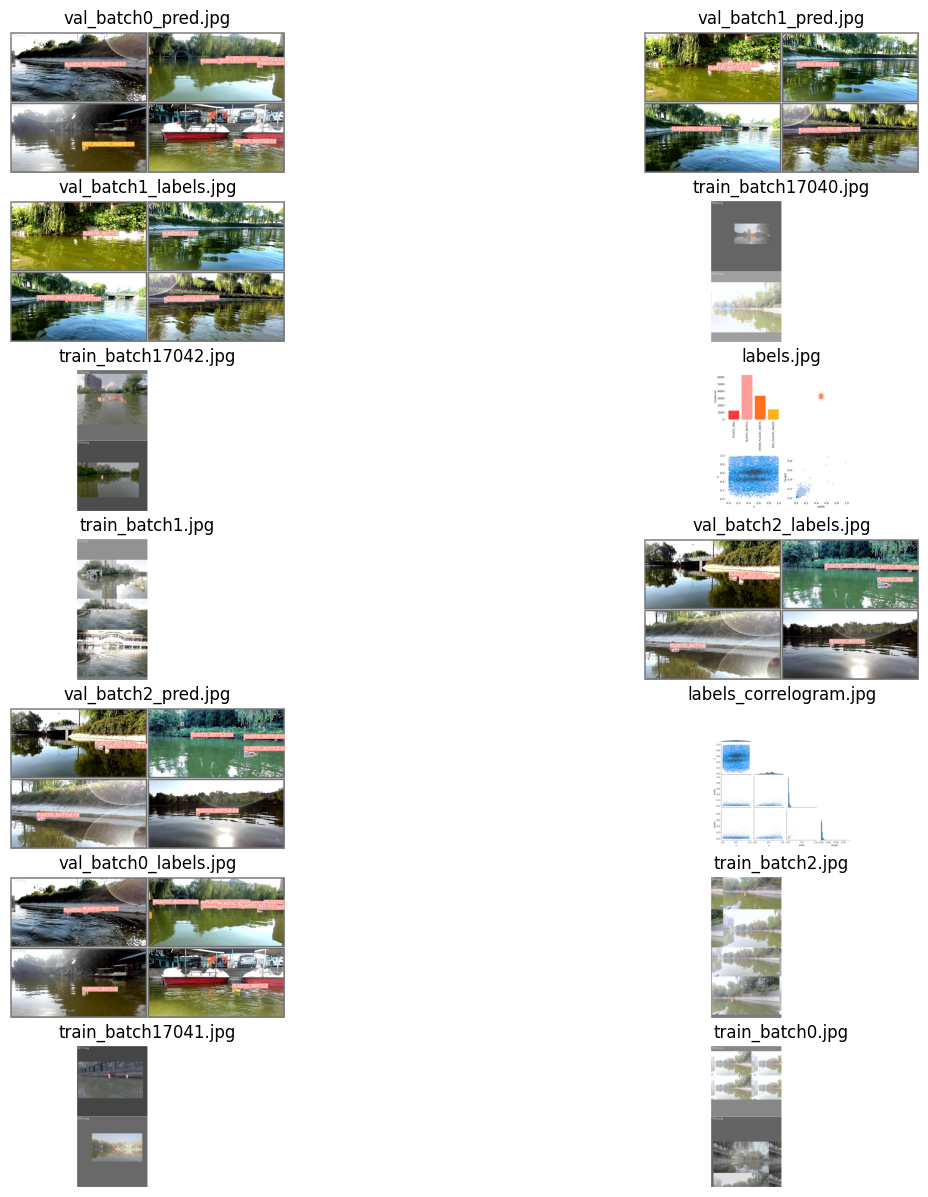

In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

directory_in_str = '/kaggle/working/runs/detect/train'
directory = os.fsencode(directory_in_str)

w = 2
h = 7
_, axes_list = plt.subplots(h, w, figsize=(15, 15)) # define a grid of (w, h)

filenames = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if(filename.endswith('.jpg')):
        filenames.append(filename)

load_img = lambda filename: np.array(Image.open(f"{directory_in_str}/{filename}"))

i =0
for axes in axes_list : 
    for ax in axes:
        ax.axis('off')
        img = filenames[i] 
        i = i+1
        ax.imshow(load_img(img))
        ax.set_title(img)

__Visualise scores and confusion matrices__

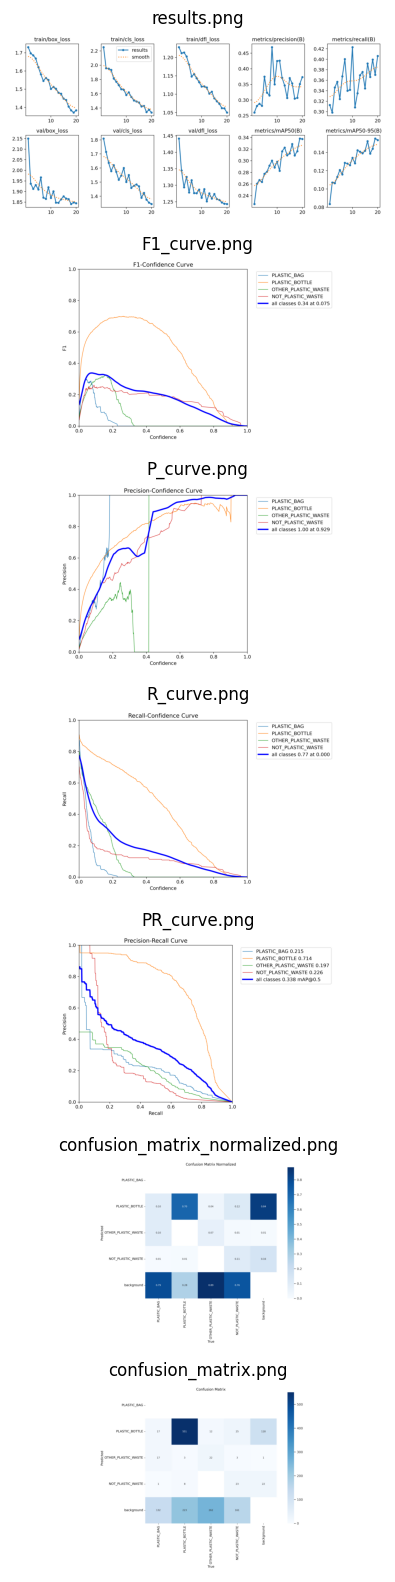

In [43]:
directory_in_str = '/kaggle/working/runs/detect/train'
directory = os.fsencode(directory_in_str)

w = 1
h = 7
_, axes_list = plt.subplots(h, w, figsize=(20, 20)) # define a grid of (w, h)

filenames = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if(filename.endswith('.png')):
        filenames.append(filename)

load_img = lambda filename: np.array(Image.open(f"{directory_in_str}/{filename}"))

i = 0
for axes in axes_list : 
    axes.axis('off')
    img = filenames[i]  # take a random train filename (like 000c34352.jpg)
    i = i+1
    axes.imshow(load_img(img)) # load and show
    axes.set_title(img)

### 6. Test model 

  0%|          | 0/3 [00:00<?, ?it/s]


0: 736x1280 2 PLASTIC_BOTTLEs, 55.8ms
Speed: 3.3ms preprocess, 55.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1.], device='cuda:0')
conf: tensor([0.4038, 0.3131], device='cuda:0')
data: tensor([[4.5899e+02, 4.3783e+02, 4.7596e+02, 4.4560e+02, 4.0377e-01, 1.0000e+00],
        [2.4367e+02, 4.3709e+02, 2.5704e+02, 4.4536e+02, 3.1308e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([2, 6])
xywh: tensor([[467.4782, 441.7145,  16.9697,   7.7643],
        [250.3535, 441.2267,  13.3701,   8.2648]], device='cuda:0')
xywhn: tensor([[0.3652, 0.6135, 0.0133, 0.0108],
        [0.1956, 0.6128, 0.0104, 0.0115]], device='cuda:0')
xyxy: tensor([[458.9934, 437.8323, 475.9631, 445.5966],
        [243.6685, 437.0942, 257.0385, 445.3591]], device='cuda:0')
xyxyn: tensor([[0.3586, 0.6081, 0.3718, 0.6189],
        [0.1904, 0.6071, 0.2008, 0.6186]], device

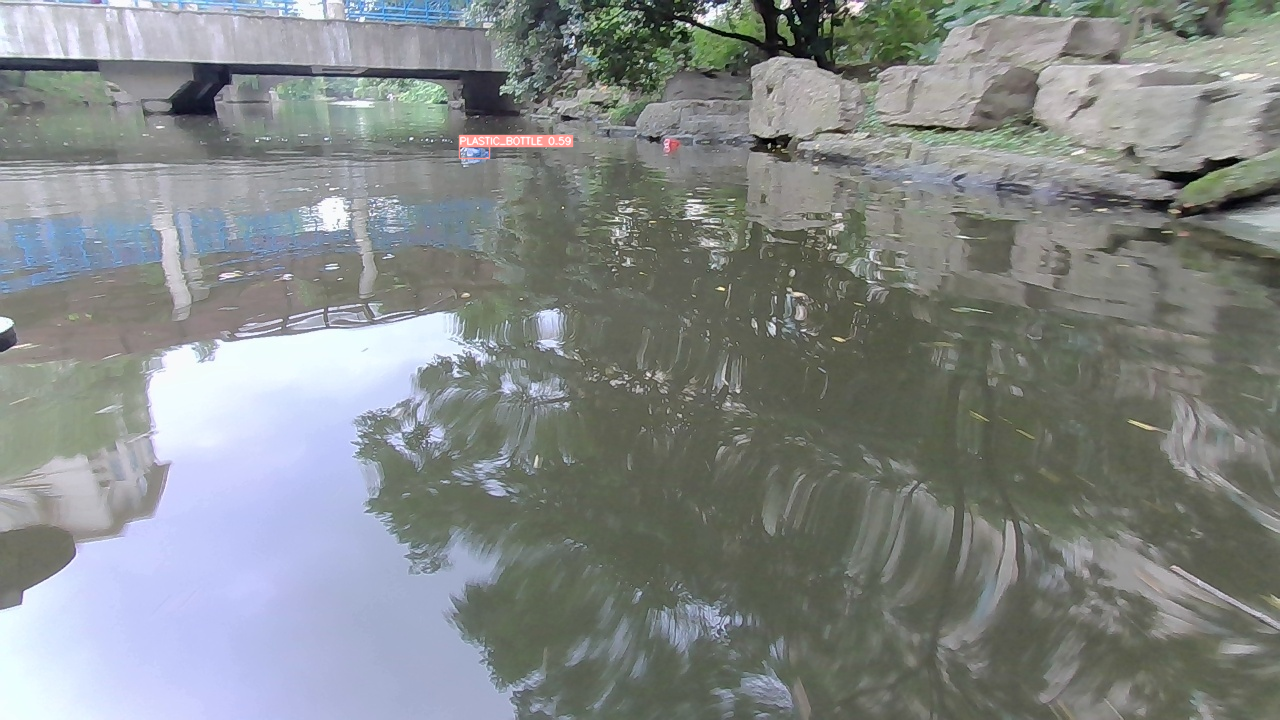

In [52]:
# test

from ultralytics import YOLO
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("kili-technology/plastic_in_river")

for i in range(5):
    img = dataset["test"][i]["image"]

    model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

    res = model.predict(img)[0]
    print(res.boxes)

    res = res.plot(line_width=1)
    res = res[:,:,::-1]    # BGR to RGB
Image.fromarray(res)

# save
# res.save("output.png")


### Conclusion
- We trained YOLOv8 on custom dataset
- Similarly we can train models for solving different problems 